<a href="https://colab.research.google.com/github/Riadh-B/Spot-the-Mask-Challenge-by-ZindiWeekendz/blob/master/Projet_Computer_vision_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Implementing our COVID-19 face mask detector training script with Keras and TensorFlow**

Projet Computer vision

M2 IASD Tunis

Work done by Riath Balti

#**Spot the Mask Challenge**


**Introduction**

---
>In a time of concerns about slowing the transmission of COVID-19, increased surveillance combined with AI solutions can improve monitoring and reduce the human effort needed to limit the spread of this disease. The objective of this challenge is to create an image classification machine learning model to accurately predict the likelihood that an image contains a person wearing a face mask, or not. The total dataset contains 1,800+ images of people either wearing masks or not.

**Goal**

---
> A machine learning solution will help policymakers, law enforcement, hospitals, and even commercial businesses ensure that masks are being worn appropriately in public. These solutions can help in the battle to reduce community transmission of COVID-19.



Here what we'll do in this kernel:


 
  1-Loading & Looking at the data 

  2-Data Preprocessing

  3-Build and Train a Baseline Model

  4-Transfer Learning v1 VGG16

  5-Transfer Learning v2 MobileNetV2








    




# Import Libraries and Define functions

In [0]:
# import the necessary packages
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
import os
from PIL import Image # used for loading images
import numpy as np
import os # used for navigating to image path
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x) #to avoid loading another version at run time (since you can't change it after it's imported)
import tensorflow as tf
import gc

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x) #to avoid loading another version at run time (since you can't change it after it's imported)`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


# Loading the dataset repository 

##Dataset Description
The data have been split into a test and training set. The training set contains ~1300 images and the test set contains 509 images. There are two types of images in this dataset, people or images with face masks and people or images without.

The task is to provide the probability that an image contains at least one mask. For each unique image ID you should estimate the likelihood that the image contains at least one mask, with an estimated probability value between 0 and 1.

## Loading zip repository from Drive 
the zip file contains all images and train csv file  list of images in the train set, 1 indicates an image with a person with a mask, 0 indicates a person without a mask. 

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
auth = GoogleAuth()
auth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(auth)

# Download a file based on its file ID.
file_id = '1fHspiD8-x82UqrUKTQePJBCHNf0Y9lSA' #-- Updated File ID for my Zip
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString(encoding='cp862')))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
dataset = io.BytesIO(downloaded.GetContentFile('Dauphine_Projet_Image2020-20200513T103049Z-001.Zip') )
!unzip /content/Dauphine_Projet_Image2020-20200513T103049Z-001.Zip

Archive:  /content/Dauphine_Projet_Image2020-20200513T103049Z-001.Zip
  inflating: Dauphine_Projet_Image2020/alfuzzlrjkdrrzauiswqnuvpvzfluc.jpg  
  inflating: Dauphine_Projet_Image2020/vvbpnstpnzspemzfccnfftwnsyfosx.jpg  
  inflating: Dauphine_Projet_Image2020/train_labels.csv  
  inflating: Dauphine_Projet_Image2020/udfpsenomwrxrlupdgqmjuzbhfpapx.jpg  
  inflating: Dauphine_Projet_Image2020/sample_sub_v2.csv  
  inflating: Dauphine_Projet_Image2020/wzdhiyzvbjlpatadxltwukvizlkpfi.jpg  
  inflating: Dauphine_Projet_Image2020/rjidoxfzbxyeffhrkzguqdqksvwtpa.jpg  
  inflating: Dauphine_Projet_Image2020/ccliaukfdmqskirlsqaemkdtziyhos.jpg  
  inflating: Dauphine_Projet_Image2020/qddqjbxtpsdrvjjdkzkycjbbrgpekf.jpg  
  inflating: Dauphine_Projet_Image2020/fljvamzsszpwkqeorlousfurjgdxlp.jpg  
  inflating: Dauphine_Projet_Image2020/xkdueyinwrnlyioamfbqqymynyyjow.jpg  
  inflating: Dauphine_Projet_Image2020/lxdnuiynpuaqxlxtcyptuyyanaovux.jpg  
  inflating: Dauphine_Projet_Image2020/lycttvvlmfidyn

In [0]:
!rm Dauphine_Projet_Image2020-20200513T103049Z-001.Zip

In [0]:
#Define Path to images 
PATH= os.getcwd()+'/Dauphine_Projet_Image2020'
PATH

'/content/Dauphine_Projet_Image2020'

In [0]:
#Now create a python dictionary, naming_dict which contains the mapping from id to labels 0 or 1.
naming_dict = {} # id: 0 or 1 (mask or not)
f = open(PATH+'/'+"train_labels.csv", "r")
next(f, None)
fileContents = f.read()
fileContents = fileContents.split('\n')
for i in range(len(fileContents)-1):
  img_file= fileContents[i].split(',')
  img_ID  =img_file[0].split('.')
  naming_dict [img_ID[0] ] = int(img_file[1])

naming_dict

{'tfymlmdkpzkqdjhdxyhnoeuqszxphw': 0,
 'rxgismgsvmaayzjarbfjaljhqmpbrt': 1,
 'uuzshfrhkgrkolhwdvliqauzulurnz': 0,
 'mjspxsagzusaznvnyxgamtrlqkqklp': 0,
 'rlbmuajgezfiddjzlyeoupxpqubkpt': 1,
 'ngvvhadzegowlxligtftkbucwyphvw': 0,
 'qlwbzgvdyqwncrvqzaezrrqlwuugdp': 1,
 'lbbmpcbdwgdbskcdmsanklchyknuig': 0,
 'xgpvctqkxpuljjixphprbdrkcuzfoi': 0,
 'tszmhququgjczggoxanwvdlzbdbxhb': 0,
 'qvqhxwbgpskanqpsfbigdmbpkenvgk': 0,
 'eqirckpknxclvrlxvfxaswsodbxlmm': 1,
 'yoewqnzdgdhogcwdageakflfeogisq': 0,
 'hpnmywojyjwgptgkflzydzenfxbtlr': 1,
 'dnzimlvqpkwyhmsdwqwpuewzbdqzmg': 1,
 'hcysrvramduefsgkkgvqbmxzlodgal': 1,
 'spdcmncwcnpqagxrlivyldeknnfcvr': 1,
 'zaemovvkdftxvorancdugwjzuodbmm': 1,
 'uvpqnqfujwsxhbgvfbvcidhcqnyuum': 0,
 'kzgroxmxsdfrkxusymupjaxumbwoow': 1,
 'cjsjioqkweumqcnobaydijuvfvtrel': 1,
 'iehmewhtlomanneoicvbyjonzzcbhh': 0,
 'uiclughuenqkjonhhjgjclflpqkhsk': 0,
 'hfbevhhmejjmdndclkpyeyaideyjgp': 1,
 'pmociluihyptefnqdlihzzodiczkso': 0,
 'qkishcozhztulvrhvodbabprxomeuq': 0,
 'gvpxmmxppq

In [0]:
#Remove csv files so we can preprocess images 
!rm /content/Dauphine_Projet_Image2020/train_labels.csv
!rm /content/Dauphine_Projet_Image2020/sample_sub_v2.csv

##Convert PNG image to JPG (RGB)
> we need to convert the images with 4 channels to RGB channels such as those in png format so as to standardize them, because our model only accepts a single fixed channels number  

In [0]:
def convert_image(PATH):  
  for img in os.listdir(PATH):
      split= img.split('.')
      imgName=split[0]
      ext=split[1]
      path = os.path.join(PATH, img)
      if ext=='png' or imread(path).shape[2]==4:
        im = Image.open(path)
        im = im.convert('RGB')  
        im.save(PATH+'/'+imgName+'.jpg', quality=95)
        os.remove(path)
  return 'Conversion completed'
convert_image(PATH)


'Conversion completed'

# Data Preprocessing

##Resizing Images
>When we are formatting images to be inputted to a Keras model, we must specify the input dimensions. Many academic datasets like CIFAR-10 or MNIST are all conveniently the same size, (32x32x3 and 28x28x1 respectively). However, in the ImageNet dataset and this spot Mask detector challenge dataset, we have many different sizes of images. First, we will write some code to loop through the images and gather some descriptive statistics on the maximum, mean, and minimum height and width of the dog images.

In [0]:
def get_size_statistics(PATH):
  heights = []
  widths = []
  for img in os.listdir(PATH): 
    path = os.path.join(PATH, img)
    data = np.array(Image.open(path)) #PIL Image library
    heights.append(data.shape[0])
    widths.append(data.shape[1])
  avg_height = sum(heights) / len(heights)
  avg_width = sum(widths) / len(widths)
  print("Average Height: ",avg_height)
  print("Max Height: ",max(heights))
  print("Min Height: ", min(heights))
  print('\n')
  print("Average Width: ",avg_width)
  print("Max Width: " ,max(widths))
  print("Min Width: " ,min(widths))

get_size_statistics(PATH)

Average Height:  446.8226872246696
Max Height:  3642
Min Height:  110


Average Width:  624.8177312775331
Max Width:  4698
Min Width:  115


In [0]:
#Resize images
def resize300(img):
    return resize(img, (128,128), preserve_range=True, mode='reflect', anti_aliasing=True)


##Loading train and test Images
> For this subsection we'll:

*   Load the dataset (train and test)
*   Encode classes (from integers into one-hot vectors)
*   Normalize images (floats & values between [0-1]) 
*   Split train set into train and validation set




In [0]:
#At this point, we’re ready to load and pre-process our training data:
def build_train_test_data(naming_dict,PATH):
  train_data = []
  test_data= []
  label_train=[]
  # loop over the image paths
  for img in os.listdir(PATH):
      imgName = img.split('.')[0]
      path = os.path.join(PATH, img)
      if imgName in naming_dict:
        # load the input image (128x128) and preprocess it
        train_data+= [np.expand_dims(resize300(imread(path)),0)]
        # extract the class label from the filename   
        label_train+= [np.expand_dims(np.array(naming_dict[imgName]),0)]
      else:
        test_data+= [np.expand_dims(resize300(imread(path)),0)]
  X_train=np.vstack(train_data)   
  X_test=np.vstack(test_data)
  Y_train=np.vstack(label_train)

  return X_train ,X_test,Y_train

X_train,X_test,Y_train=build_train_test_data(naming_dict,PATH)

In [0]:
X_train.shape,X_test.shape,Y_train.shape

((1307, 128, 128, 3), (509, 128, 128, 3), (1307, 1))

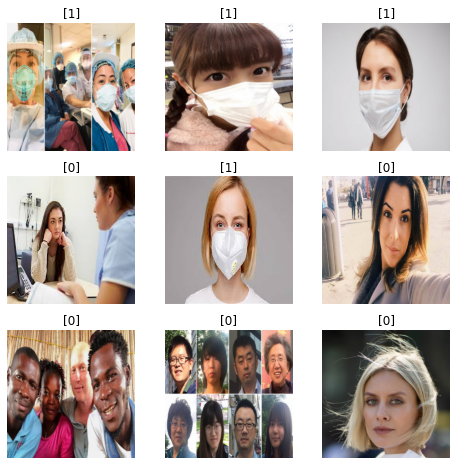

In [0]:
# Looking at some data
def display_images(images_, labels_, rows_, cols_, additional_input_=''):#sample here is an image from a dataset 
  fig = plt.figure(figsize=(8,8))
  for img in range(rows_*cols_):
    ax = fig.add_subplot(rows_,cols_,1+img)
    ax.imshow(images_[img]/255)
    ax.set_axis_off()
    if additional_input_!='':
      ax.set_title(str(labels_[img])+ ' vs: ' +str(additional_input_[img]))
    else:
      ax.set_title(str(labels_[img]))
display_images(X_train, Y_train, 3, 3)

In [0]:
def normalize(train_images_, test_images_):
	# convert from integers to floats
	train_norm = train_images_.astype('float32')
	test_norm = test_images_.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm


In [0]:
# Encode Label , Normalize and Split data
Y_train_enc = tf.keras.utils.to_categorical(Y_train)
X_train, X_test = normalize(X_train,X_test)
category_size=Y_train_enc.shape[1]
input_shape=X_train[0].shape
print('DataLoaded, And Normalized')
print('input shape:',input_shape)
print('label shape:',category_size)

DataLoaded, And Normalized
input shape: (128, 128, 3)
label shape: 2


In [0]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
validation_size = 0.2
train_images, valid_images, label_train, label_valid = train_test_split(X_train,Y_train_enc,test_size=validation_size,stratify=Y_train_enc,
                                                                        random_state=42,shuffle=True)

In [0]:
print ('The size of our training "X" (input features) is', train_images.shape)
print ('The size of our validation "X" (input features) is', valid_images.shape)
print ('The size of our training  "y" (output feature) is', label_train.shape)
print ('The size of our validation "y" (output features) is', label_valid.shape)

The size of our training "X" (input features) is (1045, 128, 128, 3)
The size of our validation "X" (input features) is (262, 128, 128, 3)
The size of our training  "y" (output feature) is (1045, 2)
The size of our validation "y" (output features) is (262, 2)


#Build and Train a Baseline Model

In [0]:
#### Create a basic model made of a convolutional bloc (e.g., at least one convolutional layer followed by a maxpooling layer)
def conv_block(filter_size_, kernel_size_, max_pooling_size_, activation_type_=None, input_shape_=None): 
  model_ = tf.keras.Sequential()
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, input_shape=input_shape_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.2))

  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*2, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*2, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.3))

  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.4))
  return model_

In [0]:
base_model = conv_block(32, (3, 3), (2, 2), activation_type_='relu', input_shape_=input_shape)


##Without Data Augmentation

In [0]:
# construct the head of the model that will be placed on top of the
# the base model
top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.Dense(1024, activation='relu'))
top_layers.add(tf.keras.layers.Dense(512, activation='relu'))
top_layers.add(tf.keras.layers.Dense(128, activation='relu'))
top_layers.add(tf.keras.layers.Dense(32, activation='relu'))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 16, 16, 128)       435488    
_________________________________________________________________
sequential_1 (Sequential)    (None, 2)                 34150114  
Total params: 34,585,602
Trainable params: 34,585,154
Non-trainable params: 448
_________________________________________________________________


In [0]:
#### Compile your model (use Adam optimizer and choose a  binary_crossentropy and metric)
epochs = 250
opt =tf.keras.optimizers.Adam(lr=0.0004, decay=0.0004 / epochs)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
augment_data=False
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  it_train = datagen.flow(train_images, train_labels_encoded, batch_size=64)

In [0]:
#### Fit the model 

if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(test_images, test_labels_encoded), verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, label_train, epochs=epochs, batch_size=64, 
                    validation_data=(valid_images, label_valid))

Training withOUT Augmented Data
Epoch 1/250
17/17 [==============================] - 2s 114ms/step - loss: 2.5138 - accuracy: 0.5292 - val_loss: 0.7099 - val_accuracy: 0.5992
Epoch 2/250
17/17 [==============================] - 1s 65ms/step - loss: 0.8671 - accuracy: 0.6038 - val_loss: 1.8509 - val_accuracy: 0.5076
Epoch 3/250
17/17 [==============================] - 1s 66ms/step - loss: 0.6311 - accuracy: 0.6842 - val_loss: 1.4669 - val_accuracy: 0.5076
Epoch 4/250
17/17 [==============================] - 1s 66ms/step - loss: 0.5098 - accuracy: 0.7541 - val_loss: 3.4490 - val_accuracy: 0.5076
Epoch 5/250
17/17 [==============================] - 1s 66ms/step - loss: 0.5086 - accuracy: 0.7770 - val_loss: 2.4009 - val_accuracy: 0.5076
Epoch 6/250
17/17 [==============================] - 1s 66ms/step - loss: 0.4355 - accuracy: 0.8182 - val_loss: 2.9544 - val_accuracy: 0.5076
Epoch 7/250
17/17 [==============================] - 1s 65ms/step - loss: 0.2795 - accuracy: 0.8842 - val_loss: 3.5

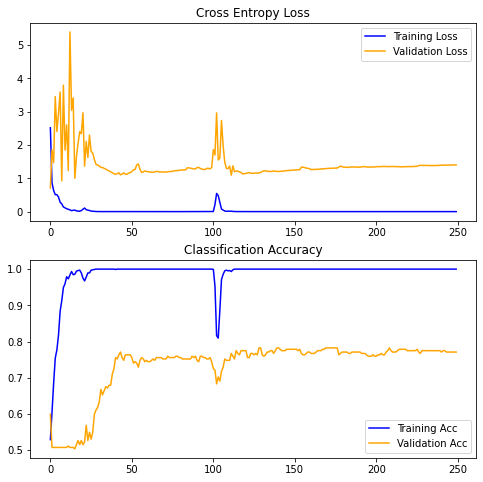

In [0]:
##### Display the loss and metric curves  
def accuracy_lost_curves(history):
  # plot loss
  fig = plt.figure(figsize=(8,8))
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history.history['loss'], color='blue', label='train')
  ax1.plot(history.history['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history.history['accuracy'], color='blue', label='train')
  ax2.plot(history.history['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  
# Learning curves
accuracy_lost_curves(history)

***Interprétation***:
D'après la figure ci dessus on distingue qu'il y a un décalge remarquable entre les deux courbes d'accuracy et de loss (train et valdiation), alros le modèle n'arrive pas à bien généraliser, il paraît bien qu'il ya un overfitting, Il y a des stratégies qui, selon moi, seraient les plus efficaces pour améliorer ce score de précision de test tels que le Data Augmentation

##With Data Augmentation

In [0]:
base_model = conv_block(32, (3, 3), (2, 2), activation_type_='relu', input_shape_=input_shape)
top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.Dense(1024, activation='relu'))
top_layers.add(tf.keras.layers.Dense(512, activation='relu'))
top_layers.add(tf.keras.layers.Dense(128, activation='relu'))
top_layers.add(tf.keras.layers.Dense(32, activation='relu'))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])

In [0]:
epochs = 250
opt =tf.keras.optimizers.Adam(lr=0.0004, decay=0.0004 / epochs)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
# construct the training image generator for data augmentation
augment_data=True
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2, 
                                                            height_shift_range=0.2,
                                                            zoom_range=0.15,
                                                            rotation_range=20,
                                                            shear_range=0.15,
                                                            fill_mode="nearest",
                                                            horizontal_flip=True)
  it_train = datagen.flow(train_images, label_train, batch_size=64)

In [0]:
#### Fit the model (you can use the test set as your validation data)
if augment_data:
  print("Training with Augmented Data")
  steps_tr = int(train_images.shape[0] / 64)
  steps_ts = int(valid_images.shape[0] / 64)

  history = model.fit(it_train, steps_per_epoch=steps_tr, 
                      epochs=epochs,
                      validation_data=(valid_images, label_valid), 
                      validation_steps=steps_ts,
                      verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))

Training with Augmented Data
Epoch 1/250
16/16 [==============================] - 4s 260ms/step - loss: 2.6598 - accuracy: 0.4822 - val_loss: 0.7063 - val_accuracy: 0.5420
Epoch 2/250
16/16 [==============================] - 4s 235ms/step - loss: 1.2541 - accuracy: 0.4980 - val_loss: 0.6971 - val_accuracy: 0.4962
Epoch 3/250
16/16 [==============================] - 4s 226ms/step - loss: 0.8476 - accuracy: 0.5872 - val_loss: 0.8669 - val_accuracy: 0.5038
Epoch 4/250
16/16 [==============================] - 4s 222ms/step - loss: 0.9013 - accuracy: 0.5433 - val_loss: 0.7101 - val_accuracy: 0.5534
Epoch 5/250
16/16 [==============================] - 4s 226ms/step - loss: 0.7405 - accuracy: 0.5984 - val_loss: 0.8423 - val_accuracy: 0.5076
Epoch 6/250
16/16 [==============================] - 4s 227ms/step - loss: 0.7084 - accuracy: 0.6096 - val_loss: 0.6749 - val_accuracy: 0.5687
Epoch 7/250
16/16 [==============================] - 4s 221ms/step - loss: 0.6799 - accuracy: 0.6024 - val_loss: 

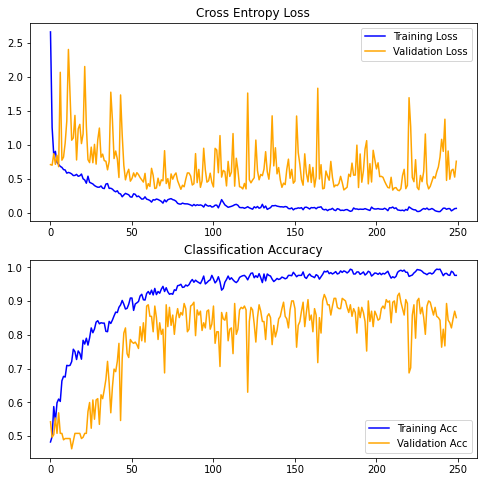

In [0]:
##### Display the loss and metric curves  
def accuracy_lost_curves(history):
  # plot loss
  fig = plt.figure(figsize=(8,8))
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history.history['loss'], color='blue', label='train')
  ax1.plot(history.history['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history.history['accuracy'], color='blue', label='train')
  ax2.plot(history.history['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  
# Learning curves
accuracy_lost_curves(history)

***Interprétation***:
Ici on distingue qu'il y a un décalge entre les deux courbes s'est diminué en utilisant le data augmentaion technique , alros le modèle arrive à mieux généraliser.On arrive à 86% de validation accuracy

#Transfer Learning with Data Augmentation

##Transfer Learning_V1:VGG16

> ***In this section:***
The Pre-processing steps include resizing to 224×224 pixels, conversion to array format, and scaling the pixel intensities in the input image to the range [-1, 1] (via the preprocess_input convenience function of VGG16)

In [0]:

def resize300(img):
    return resize(img, (224,224), preserve_range=True, mode='reflect', anti_aliasing=True)

def build_train_test_data(naming_dict,PATH):
  train_data = []
  test_data= []
  label_train=[]
  for img in os.listdir(PATH):
      imgName = img.split('.')[0]
      path = os.path.join(PATH, img)
      if imgName in naming_dict:
        train_data+= [np.expand_dims(tf.keras.applications.vgg16.preprocess_input(resize300(imread(path))),0)]  
        label_train+= [np.expand_dims(np.array(naming_dict[imgName]),0)]
      else:
        test_data+= [np.expand_dims(tf.keras.applications.vgg16.preprocess_input(resize300(imread(path))),0)]
  X_train=np.vstack(train_data)   
  X_test=np.vstack(test_data)
  Y_train=np.vstack(label_train)

  return X_train ,X_test,Y_train

X_train,X_test,Y_train=build_train_test_data(naming_dict,PATH)

In [0]:
X_train.shape,X_test.shape,Y_train.shape

((1307, 224, 224, 3), (509, 224, 224, 3), (1307, 1))

In [0]:
Y_train_enc = tf.keras.utils.to_categorical(Y_train)
category_size=Y_train_enc.shape[1]
input_shape=X_train[0].shape
print('DataLoaded, And Normalized')
print('input shape:',input_shape)
print('label shape:',category_size)

DataLoaded, And Normalized
input shape: (224, 224, 3)
label shape: 2


In [0]:
# Split-out validation dataset
validation_size = 0.2
train_images, valid_images, label_train, label_valid = train_test_split(X_train,Y_train_enc,test_size=validation_size,stratify=Y_train_enc,
                                                                        random_state=42,shuffle=True)

In [0]:
print ('The size of our training "X" (input features) is', train_images.shape)
print ('The size of our validation "X" (input features) is', valid_images.shape)
print ('The size of our training  "y" (output feature) is', label_train.shape)
print ('The size of our validation "y" (output features) is', label_valid.shape)

The size of our training "X" (input features) is (1045, 224, 224, 3)
The size of our validation "X" (input features) is (262, 224, 224, 3)
The size of our training  "y" (output feature) is (1045, 2)
The size of our validation "y" (output features) is (262, 2)


***we need now to prepare VGG16 for fine-tuning:***

---



In [0]:
# load the VGG16 network, ensuring the head FC layer sets are
# left off
base_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape=input_shape)
base_model.trainable = False  # loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# construct the head of the model that will be placed on top of the
# the base model
top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.GlobalAveragePooling2D())
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.Dense(128, activation='relu'))
top_layers.add(tf.keras.layers.BatchNormalization())
top_layers.add(tf.keras.layers.Dropout(0.9))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
sequential_6 (Sequential)    (None, 2)                 66434     
Total params: 14,781,122
Trainable params: 66,178
Non-trainable params: 14,714,944
_________________________________________________________________


In [0]:
epochs = 150
opt =tf.keras.optimizers.Adam(lr=0.0004, decay=0.0004 / epochs)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
augment_data=True
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2, 
                                                            height_shift_range=0.2,
                                                            zoom_range=0.15,
                                                            rotation_range=20,
                                                            shear_range=0.15,
                                                            fill_mode="nearest",
                                                            horizontal_flip=True)
  it_train = datagen.flow(train_images, label_train, batch_size=64)

In [0]:
#### Fit the model (you can use the test set as your validation data)
if augment_data:
  print("Training with Augmented Data")
  steps_tr = int(train_images.shape[0] / 64)
  steps_ts = int(valid_images.shape[0] / 64)

  history = model.fit(it_train, steps_per_epoch=steps_tr, 
                      epochs=epochs,
                      validation_data=(valid_images, label_valid), 
                      validation_steps=steps_ts,
                      verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))

Training with Augmented Data
Epoch 1/150
16/16 [==============================] - 11s 694ms/step - loss: 2.1510 - accuracy: 0.5464 - val_loss: 0.8951 - val_accuracy: 0.7214
Epoch 2/150
16/16 [==============================] - 11s 669ms/step - loss: 1.6667 - accuracy: 0.5933 - val_loss: 0.5161 - val_accuracy: 0.7977
Epoch 3/150
16/16 [==============================] - 10s 656ms/step - loss: 1.5456 - accuracy: 0.6055 - val_loss: 0.4392 - val_accuracy: 0.8206
Epoch 4/150
16/16 [==============================] - 11s 658ms/step - loss: 1.4139 - accuracy: 0.6463 - val_loss: 0.3882 - val_accuracy: 0.8511
Epoch 5/150
16/16 [==============================] - 10s 654ms/step - loss: 1.2745 - accuracy: 0.6707 - val_loss: 0.3503 - val_accuracy: 0.8511
Epoch 6/150
16/16 [==============================] - 10s 651ms/step - loss: 1.1249 - accuracy: 0.6993 - val_loss: 0.3161 - val_accuracy: 0.8817
Epoch 7/150
16/16 [==============================] - 11s 657ms/step - loss: 0.9062 - accuracy: 0.7095 - val

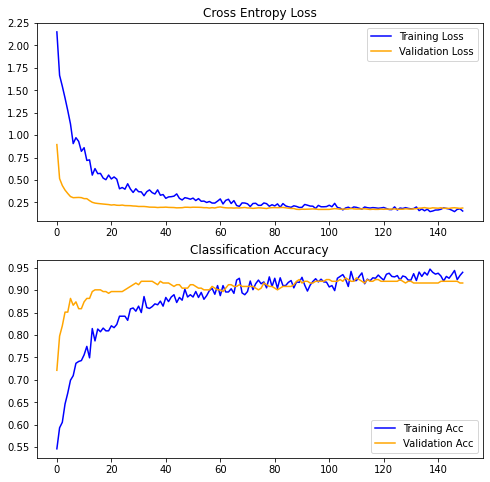

In [0]:
##### Display the loss and metric curves  
def accuracy_lost_curves(history):
  # plot loss
  fig = plt.figure(figsize=(8,8))
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history.history['loss'], color='blue', label='train')
  ax1.plot(history.history['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history.history['accuracy'], color='blue', label='train')
  ax2.plot(history.history['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  
# Learning curves
accuracy_lost_curves(history)

***Interprétation***:
D'après la figure ci dessus on distingue qu'il n'y aucun décalge entre les deux courbes d'accuracy et de loss (train et valdiation), cependant on remarque qu'au debut des itérations(jusqu'à 80 itérations) la courbe de validation que soit pour accuracy ou loss est au dessus de celle de train, ceci est dû principalement des poids gelés du modèle pré-entrainé(VGG16), ils marchent très bien avec nos images, alors que les poids de ceux du Head (FCN) sont en train d'apprendre,  alros le modèle arrive à très  bien généraliser, on arrive à 95%

##Transfer Learning_V2: MobileNetV2

> ***In this section:***
The Pre-processing steps include resizing to 224×224 pixels, conversion to array format, and scaling the pixel intensities in the input image to the range [-1, 1] (via the preprocess_input convenience function of MobileNetV2)

In [0]:

def resize300(img):
    return resize(img, (224,224), preserve_range=True, mode='reflect', anti_aliasing=True)

def build_train_test_data(naming_dict,PATH):
  train_data = []
  test_data= []
  label_train=[]
  for img in os.listdir(PATH):
      imgName = img.split('.')[0]
      path = os.path.join(PATH, img)
      if imgName in naming_dict:
        train_data+= [np.expand_dims(tf.keras.applications.mobilenet_v2.preprocess_input(resize300(imread(path))),0)]  
        label_train+= [np.expand_dims(np.array(naming_dict[imgName]),0)]
      else:
        test_data+= [np.expand_dims(tf.keras.applications.mobilenet_v2.preprocess_input(resize300(imread(path))),0)]
  X_train=np.vstack(train_data)   
  X_test=np.vstack(test_data)
  Y_train=np.vstack(label_train)

  return X_train ,X_test,Y_train

X_train,X_test,Y_train=build_train_test_data(naming_dict,PATH)

In [0]:
X_train.shape,X_test.shape,Y_train.shape

((1307, 224, 224, 3), (509, 224, 224, 3), (1307, 1))

In [0]:
Y_train_enc = tf.keras.utils.to_categorical(Y_train)
category_size=Y_train_enc.shape[1]
input_shape=X_train[0].shape
print(' DataLoaded, And Normalized')
print('input shape:',input_shape)
print('label shape:',category_size)

 DataLoaded, And Normalized
input shape: (224, 224, 3)
label shape: 2


In [0]:
# Split-out validation dataset
validation_size = 0.2
train_images, valid_images, label_train, label_valid = train_test_split(X_train,Y_train_enc,test_size=validation_size,stratify=Y_train_enc,
                                                                        random_state=42,shuffle=True)

In [0]:
print ('The size of our training "X" (input features) is', train_images.shape)
print ('The size of our validation "X" (input features) is', valid_images.shape)
print ('The size of our training  "y" (output feature) is', label_train.shape)
print ('The size of our validation "y" (output features) is', label_valid.shape)

The size of our training "X" (input features) is (1045, 224, 224, 3)
The size of our validation "X" (input features) is (262, 224, 224, 3)
The size of our training  "y" (output feature) is (1045, 2)
The size of our validation "y" (output features) is (262, 2)


***we need now to prepare MobileNetV2 for fine-tuning:***

---



In [0]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
base_model = tf.keras.applications.MobileNetV2(weights = 'imagenet', include_top = False, input_shape=input_shape)
base_model.trainable = False # loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.GlobalAveragePooling2D())
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.Dense(128, activation='relu'))
top_layers.add(tf.keras.layers.BatchNormalization())
top_layers.add(tf.keras.layers.Dropout(0.9))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])

In [0]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
sequential_8 (Sequential)    (None, 2)                 164738    
Total params: 2,422,722
Trainable params: 164,482
Non-trainable params: 2,258,240
_________________________________________________________________


In [0]:
epochs = 150
opt =tf.keras.optimizers.Adam(lr=0.0004, decay=0.0004 / epochs)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
augment_data=True
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2, 
                                                            height_shift_range=0.2,
                                                            zoom_range=0.15,
                                                            rotation_range=20,
                                                            shear_range=0.15,
                                                            fill_mode="nearest",
                                                            horizontal_flip=True)
  it_train = datagen.flow(train_images, label_train, batch_size=64)

In [0]:
#### Fit the model (you can use the test set as your validation data)
if augment_data:
  print("Training with Augmented Data")
  steps_tr = int(train_images.shape[0] / 64)
  steps_ts = int(valid_images.shape[0] / 64)

  history = model.fit(it_train, steps_per_epoch=steps_tr, 
                      epochs=epochs,
                      validation_data=(valid_images, label_valid), 
                      validation_steps=steps_ts,
                      verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))

Training with Augmented Data
Epoch 1/150
16/16 [==============================] - 11s 711ms/step - loss: 2.0640 - accuracy: 0.5505 - val_loss: 0.4243 - val_accuracy: 0.8168
Epoch 2/150
16/16 [==============================] - 10s 631ms/step - loss: 1.4703 - accuracy: 0.6575 - val_loss: 0.3006 - val_accuracy: 0.8893
Epoch 3/150
16/16 [==============================] - 10s 631ms/step - loss: 0.9467 - accuracy: 0.7543 - val_loss: 0.2783 - val_accuracy: 0.8740
Epoch 4/150
16/16 [==============================] - 10s 630ms/step - loss: 0.7969 - accuracy: 0.7594 - val_loss: 0.2752 - val_accuracy: 0.8702
Epoch 5/150
16/16 [==============================] - 11s 665ms/step - loss: 0.8177 - accuracy: 0.7808 - val_loss: 0.2769 - val_accuracy: 0.8664
Epoch 6/150
16/16 [==============================] - 10s 628ms/step - loss: 0.6990 - accuracy: 0.8073 - val_loss: 0.2862 - val_accuracy: 0.8702
Epoch 7/150
16/16 [==============================] - 10s 618ms/step - loss: 0.7005 - accuracy: 0.8063 - val

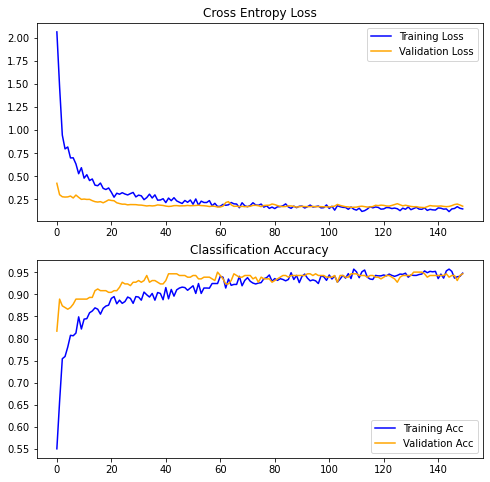

In [0]:
##### Display the loss and metric curves  
def accuracy_lost_curves(history):
  # plot loss
  fig = plt.figure(figsize=(8,8))
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history.history['loss'], color='blue', label='train')
  ax1.plot(history.history['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history.history['accuracy'], color='blue', label='train')
  ax2.plot(history.history['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  
# Learning curves
accuracy_lost_curves(history)

***Interprétation***:
D'après la figure ci dessus on distingue qu'il n'y aucun décalge entre les deux courbes d'accuracy et de loss (train et valdiation), cependant on remarque qu'au debut des itérations(jusqu'à 80 itérations) la courbe de validation que soit pour accuracy et loss est au dessus de celle de train, ceci est dû principalement des poids gelés du modèle pré-entrainé(MobileNetV2), ils marchent très bien avec nos images,  alros le modèle arrive à très  bien généraliser, on arrive à 95%